# Siamese Networks

Neural networks are great, but they need data in such a huge amount. The more we are working on real world applications, the bigger our data luggage has to be. It's a fundamental rule of deep learning, it usually doesn't change significantly, modifying our architecture. We have solutions to this problem:
<ul>
    <li>we can augment our dataset;</li>
    <li>we can make use of transfer learning and use a model already trained;</li>
    <li>siamese networks</li>
</ul>
Siamese networks are networks specialized in a <em>similarity prediction</em> task. They can process images, or  text. and they don't need a big quantity of data. They need more training and they don't output probabilities, but being able to proceed in environments with lack of big data grew their popularity in recent years.<br>
Building a <em>Siamese Network</em> from scratch is not difficult at all, using the <em>TensorFlow Functional API</em> it gets super-easy. Let's take a look. 

## Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random
import utilities

## Dataset

<em>Fashion MNIST</em> is a widely available dataset, composed of Zalando's article images. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [2]:
# downloading and preparing train and test set

# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# casting as float and normalizing
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = utilities.create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = utilities.create_pairs_on_set(test_images, test_labels)

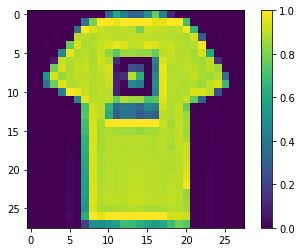

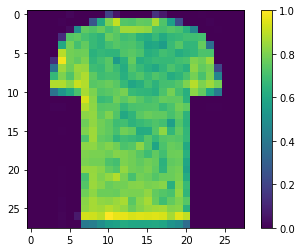

1.0


In [3]:
# checking a pair of images

# array index
this_pair = 20

# show images at this index
utilities.show_image(ts_pairs[this_pair][0])
utilities.show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(tr_y[this_pair])

## Model

Time to build the model using the Functional API.

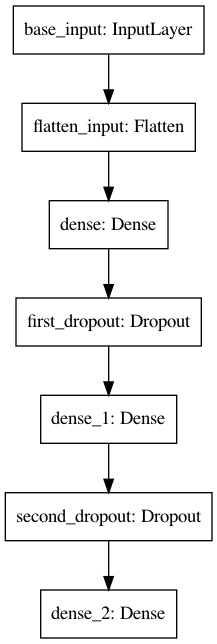

In [4]:
# building base model architecture

input = Input(shape=(28,28,), name="base_input")

x = Flatten(name="flatten_input")(input)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1, name="first_dropout")(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1, name="second_dropout")(x)
x = Dense(128, activation='relu')(x)

base_model = Model(inputs=input, outputs=x)

plot_model(base_model, show_shapes=False, show_layer_names=True, to_file='base-model.png')

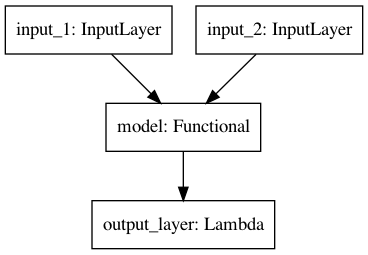

In [5]:
# building siamese network

# create the left input and point to the base network
input_a = Input(shape=(28,28,))
vect_output_a = base_model(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,))
vect_output_b = base_model(input_b)

# measure the similarity of the two vector outputs
output = Lambda(utilities.euclidean_distance, name="output_layer", 
                output_shape=utilities.eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
siamese_model = Model([input_a, input_b], output)

# plot model graph
plot_model(siamese_model, show_shapes=False, show_layer_names=True, to_file='outer-model.png')

In [6]:
# compiling model

siamese_model.compile(loss=utilities.contrastive_loss_with_margin(margin=1), optimizer='rmsprop')

In [7]:
history = siamese_model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, 
                            validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 7s 6ms/step - loss: 0.1495 - val_loss: 0.0832
Epoch 2/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0834 - val_loss: 0.0770
Epoch 3/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0726 - val_loss: 0.0686
Epoch 4/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0678 - val_loss: 0.0672
Epoch 5/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0641 - val_loss: 0.0697
Epoch 6/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0612 - val_loss: 0.0674
Epoch 7/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0596 - val_loss: 0.0650
Epoch 8/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0589 - val_loss: 0.0646
Epoch 9/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0573 - val_loss: 0.0633
Epoch 10/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0564 - val_loss: 0.0628

### Model Evaluation

In [8]:
loss = siamese_model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = siamese_model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = utilities.compute_accuracy(tr_y, y_pred_train)

y_pred_test = siamese_model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = utilities.compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 1ms/step - loss: 0.0619
Loss = 0.061882879585027695, Train Accuracy = 0.061185197532922155 Test Accuracy = 0.08398398398398399


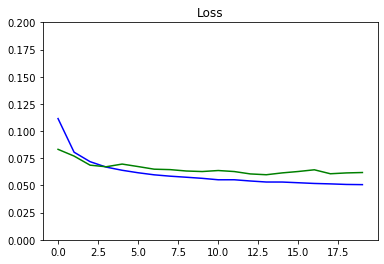

In [9]:
utilities.plot_metrics(history=history, metric_name='loss', title="Loss", ylim=0.2)

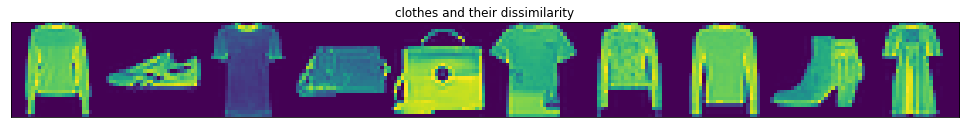

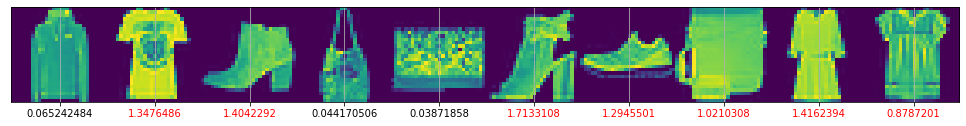

In [11]:
# sampling results from 10 pair of items

y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
utilities.display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], 
                         y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)

As we can see, an advanced architecture like <em>Siamese Networks</em> can be built built in no time with TensorFlow 2. The label shown for every pair of items tells us how similar these piece of clothing are: close to 0 means similar, close to 1 (even more) means dissimilar.<br>
Thanks to <em>Laurence Moroney</em> and his great course <em>Custom Models, Layers, and Loss Functions with TensorFlow</em>, part of the <em>TensorFlow: Advanced Techniques Specialization</em>, offered by <em>Coursera</em>.